#### Create parent folder for custom model training and child folders to store data

In [43]:
import os

current_path = os.getcwd()
print("Current working directory:", current_path)

# Create a folder in the current working directory and name it autonomous_vehicle
# upload the images.zip file in this folder
# Check if the file is uploaded and zip file exists

folder_path = '/content/autonomous_vehicle'
#zip_filename = 'images.zip'
#zip_path = os.path.join(folder_path, zip_filename)
#print(zip_path)
# the code above does not work ! WHY?

zip_path = '/content/autonomous_vehicle/Images.zip'

if os.path.isfile(zip_path):
    print("ZIP file exists.No need to copy files")
else:
    print("ZIP file does not exist. Copy files in this folder")

Current working directory: /content
ZIP file exists.No need to copy files


In [46]:
import os
import shutil

# Define destination folder
extract_to = '/content/autonomous_vehicle'

# Check if folder exists and is non-empty
if not os.path.exists(extract_to) or not os.listdir(extract_to):
    # Create the folder if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)

    # Extract the ZIP file
    shutil.unpack_archive(zip_path, extract_to)
    print("Extraction complete.")
else:
    print("Destination folder already exists and is not empty. Skipping extraction.")

# Proceed to upload labels_5657.csv
# (Assuming you're using pandas or another method to load it)
# Example:
# import pandas as pd
# labels_df = pd.read_csv(os.path.join(extract_to, 'labels_5557.csv'))


Destination folder already exists and is not empty. Skipping extraction.


In [47]:
# List all files and folders inside the specified directory
#folder_path = '/content/autonomous_vehicle'
if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print("Contents of 'autonomous_vehicle':")
    for file in files:
        print(file)
else:
    print("Folder 'autonomous_vehicle' does not exist.")


Contents of 'autonomous_vehicle':
labels_5557.csv
Images.zip
Images
.ipynb_checkpoints


In [48]:
# Define the path to the folder
#images_dir = 'Images/'
images_dir = '/content/autonomous_vehicle/Images/'
# Count files (excluding subdirectories)
file_count = len([f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))])

print(f"Number of files in '{images_dir}' folder: {file_count}")

Number of files in '/content/autonomous_vehicle/Images/' folder: 5626


In [49]:
import os

def get_folder_size(path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            if os.path.isfile(filepath):
                total_size += os.path.getsize(filepath)
    return total_size

# Example usage
folder_path = '/content/autonomous_vehicle/Images/'
size_bytes = get_folder_size(folder_path)
size_mb = size_bytes / (1024 * 1024)

print(f"Total size of '{folder_path}' folder: {size_mb:.2f} MB")


Total size of '/content/autonomous_vehicle/Images/' folder: 135.57 MB


In [50]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras import layers
from keras.layers import BatchNormalization

### Prepare the dataset for model training

In [52]:
#### Step 2: Load and preprocess the data
# Load the labels from labels.csv
labels_df = pd.read_csv('/content/autonomous_vehicle/labels_5557.csv', sep=',', header=None)
labels_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']
# Adjust the image IDs in the dataframe
labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")
labels_df.head(5)

,image_id,class,x_min,y_min,x_max,y_max
0,00000000,pickup_truck,213,34,255,50
1,00000000,car,194,78,273,122
2,00000000,car,155,27,183,35
3,00000000,articulated_truck,43,25,109,55
4,00000000,car,106,32,124,45


In [53]:
labels_df.shape

(17623, 6)

In [54]:
# List unique image_ids from the dataset
unique_ids = labels_df['image_id'].unique()
print(unique_ids.shape)
print(unique_ids.min())
print(unique_ids.max())

(5527,)
00000000
00005557


In [63]:
# Get all filenames in the directory, stripped of extensions
existing_files = {os.path.splitext(f)[0] for f in os.listdir(images_dir)}
f_N = len(unique_ids)
# Check which unique_ids are missing
print('The files with the following unique_ids are missing in the folder')
missing_files = []

for n in range(0,f_N):
    uid_str = f"{n:08d}"
    if uid_str not in existing_files:
      missing_files.append(uid_str)
      print(uid_str)



The files with the following unique_ids are missing in the folder
00000314
00000554
00000568
00000623
00001044
00001119
00001276
00001432
00001485
00001543
00001722
00001792
00001802
00001941
00002208
00002270
00002388
00002452
00002494
00002805
00002902
00002956
00003335
00004615
00004842
00005069
00005320
00005363
00005370
00005432


In [68]:
# Ensure missing_files are formatted as strings with zero-padding
missing_ids_str = [f"{int(mid):08d}" for mid in missing_files]

# Ensure image_id column is also formatted as zero-padded strings
labels_df['image_id'] = labels_df['image_id'].astype(str).apply(lambda x: f"{int(x):08d}")

# Filter out rows with missing image IDs
#labels_df = labels_df[~labels_df['image_id'].isin(missing_ids_str)]

# Step 1: Create a boolean mask for rows where image_id is NOT in the list of missing IDs
keep_rows_mask = ~labels_df['image_id'].isin(missing_ids_str)

# Step 2: Use the mask to filter the DataFrame and keep only valid rows
labels_df = labels_df[keep_rows_mask]

# Print updated shape
print(f"✅ Updated labels_df shape: {labels_df.shape}")



Filtered labels_df shape: (17623, 6)
✅ Updated labels_df shape: (17623, 6)


In [69]:
# List unique image_ids from the dataset
unique_ids = labels_df['image_id'].unique()
print(unique_ids.shape)
print(unique_ids.min())
print(unique_ids.max())

(5527,)
00000000
00005557


In [66]:
import os
from PIL import Image
import numpy as np

# Directory containing images
images_dir = '/content/autonomous_vehicle/Images/'

# Dictionary to hold image data
image_dict = {}

# Loop through image files
for filename in os.listdir(images_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        img_path = os.path.join(images_dir, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensure consistent format
            img_array = np.array(img)
            image_id = os.path.splitext(filename)[0]   # Remove file extension
            image_dict[image_id] = img_array
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Summary
print(f"{len(image_dict)} images loaded successfully.")


5626 images loaded successfully.


00000002
    image_id              class  x_min  y_min  x_max  y_max
11  00000002  motorized_vehicle    334    362    603    479
Image size: 720x480


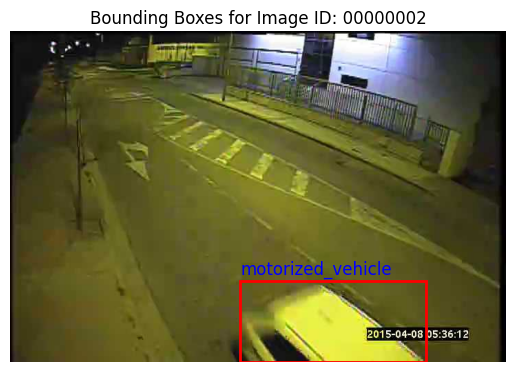

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# User input Needed - Pick the target image_id in the dataset
# Choose N=0 to pick the first image_id from the list of unique_ids
N=2 # This is not the image_id, just the identifier for Unique_id list

target_id = unique_ids[N] # this is the image_id
print(target_id)

# Filter the rows of the labels_df dataset with the same image_id
# Rationale - there might be multiple rows of bounding boxes for same image_id
filtered_df = labels_df[labels_df['image_id'] == target_id]

# Display the first few rows to check the bounding box parameters
print(filtered_df.head())

#target_image = images[N]
target_image = image_dict[target_id]

# pixel size of the target_image
image_height, image_width, _ = target_image.shape
print(f"Image size: {image_width}x{image_height}")

# Display the image
plt.imshow(target_image)
plt.axis('off')  # Turn off axis labels and ticks


# Add bounding boxes
ax = plt.gca()  # Get current axes

for _, row in filtered_df.iterrows():
    x_min, y_min = row['x_min'], row['y_min']
    x_max, y_max = row['x_max'], row['y_max']
    width = x_max - x_min
    height = y_max - y_min

    # Create rectangle
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    class_name = row['class']
    plt.text(x_min, y_min - 10, class_name, color='blue', fontsize=12)

plt.title(f"Bounding Boxes for Image ID: {target_id}")
plt.show()

# write the class identifier on the picture


Button(description='Next Image', style=ButtonStyle())

🔍 Reviewing Image ID: 00000003
    image_id class  x_min  y_min  x_max  y_max
12  00000003   car    480     99    511    120
13  00000003   car    257    199    369    280
Image size: 720x480


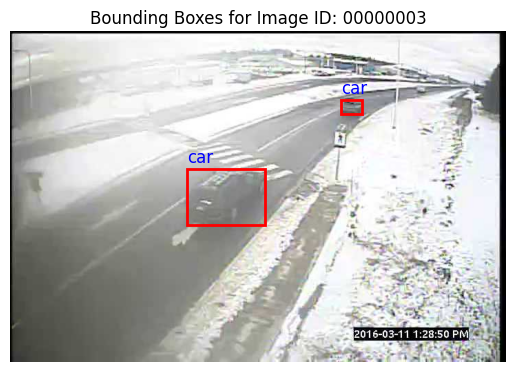

In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create a button widget
next_button = widgets.Button(description="Next Image")

# Iterator over image IDs
image_iterator = iter(unique_ids)

def on_button_click(b):
    clear_output(wait=True)
    display(next_button)

    try:
        target_id = next(image_iterator)
        print(f"🔍 Reviewing Image ID: {target_id}")

        filtered_df = labels_df[labels_df['image_id'] == target_id]
        print(filtered_df.head())

        target_image = image_dict[target_id]
        image_height, image_width, _ = target_image.shape
        print(f"Image size: {image_width}x{image_height}")

        fig, ax = plt.subplots()
        ax.imshow(target_image)
        ax.axis('off')

        for _, row in filtered_df.iterrows():
            x_min, y_min = row['x_min'], row['y_min']
            x_max, y_max = row['x_max'], row['y_max']
            width = x_max - x_min
            height = y_max - y_min

            rect = patches.Rectangle((x_min, y_min), width, height,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min - 10, row['class'], color='blue', fontsize=12)

        plt.title(f"Bounding Boxes for Image ID: {target_id}")
        plt.show()

    except StopIteration:
        print("✅ All images reviewed.")

# Link button to function
next_button.on_click(on_button_click)

# Display the button to start
display(next_button)


Observations:


*   Images are not of same sizes
    *   720 x 480
    *   342 X 228

*   Each image might have multiple bounding boxes. SOme of these boxes are very small!




In [72]:
import pandas as pd

# Create a summary of the first 5 images
summary = [
    {"image_id": img_id, "shape": img_array.shape}
    for img_id, img_array in list(image_dict.items())[:5]
]

# Display as DataFrame
pd.DataFrame(summary)

,image_id,shape
0,00003726,"(228, 342, 3)"
1,00002492,"(228, 342, 3)"
2,00003700,"(480, 720, 3)"
3,00000439,"(228, 342, 3)"
4,00004239,"(480, 720, 3)"


In [73]:
import pandas as pd

# Target dimensions
target_width = 720
target_height = 480

# Filter image_ids with matching dimensions
valid_ids = []
for image_id, img_array in image_dict.items():
    if img_array.shape[1] == target_width and img_array.shape[0] == target_height:
        valid_ids.append(image_id)

# Filter labels_df based on valid image_ids
filtered_labels = labels_df[labels_df['image_id'].isin(valid_ids)]

# Define the folder path and filename
folder_path = '/content/autonomous_vehicle'
output_file = f"{folder_path}/labels_5557_batch1.csv"

# Save the filtered DataFrame
os.makedirs(folder_path, exist_ok=True)
filtered_labels.to_csv(output_file, index=False)

print(f"✅ File saved at: {output_file}")
print(f"✅ Saved {len(filtered_labels)} label entries for images sized {target_width}x{target_height}.")



✅ File saved at: /content/autonomous_vehicle/labels_5557_batch1.csv
✅ Saved 14333 label entries for images sized 720x480.


In [74]:
# Save images to new folder
image_output_folder = os.path.join(folder_path, 'images_batch1')
os.makedirs(image_output_folder, exist_ok=True)

for image_id in valid_ids:
    img_array = image_dict[image_id]
    img = Image.fromarray(img_array)
    img.save(os.path.join(image_output_folder, f"{image_id}.png"))

print(f"✅ Saved {len(valid_ids)} images to: {image_output_folder}")

✅ Saved 4462 images to: /content/autonomous_vehicle/images_batch1


In [75]:
# Load and preprocess the data
# Load the labels from labels_5657_atch1.csv
labels_batch1_df = pd.read_csv('/content/autonomous_vehicle/labels_5557_batch1.csv', sep=',', header=None)
labels_batch1_df.columns = ['image_id', 'class', 'x_min', 'y_min', 'x_max', 'y_max']
# Adjust the image IDs in the dataframe
#labels_df['image_id'] = labels_df['image_id'].apply(lambda x: f"{x:08d}")
labels_batch1_df

,image_id,class,x_min,y_min,x_max,y_max
0,image_id,class,x_min,y_min,x_max,y_max
1,00000001,bus,205,155,568,314
2,00000001,bus,285,123,477,168
3,00000001,car,544,162,617,193
4,00000001,car,329,152,371,163
...,...,...,...,...,...,...
14329,00005555,car,124,237,307,368
14330,00005555,car,573,58,587,70
14331,00005556,car,152,95,385,202
14332,00005557,car,234,84,255,101


In [76]:
# Analyze the distribution of vehicle types in the limited dataset
vehicle_types = labels_batch1_df['class'].value_counts()
print("Distribution of vehicle types:")
print(vehicle_types)



Distribution of vehicle types:
class
car                      9803
pickup_truck             1451
motorized_vehicle         984
bus                       523
work_van                  356
articulated_truck         348
pedestrian                328
single_unit_truck         237
bicycle                   128
motorcycle                 89
non-motorized_vehicle      86
class                       1
Name: count, dtype: int64


In [77]:
labels_batch1_df.head(5)


,image_id,class,x_min,y_min,x_max,y_max
0,image_id,class,x_min,y_min,x_max,y_max
1,00000001,bus,205,155,568,314
2,00000001,bus,285,123,477,168
3,00000001,car,544,162,617,193
4,00000001,car,329,152,371,163


In [78]:
labels_batch1_df.tail(1)

,image_id,class,x_min,y_min,x_max,y_max
14333,00005557,car,141,176,210,254


In [79]:
from PIL import Image
import numpy as np
# Load the corresponding images
#images_dir = 'Images/'
images_batch1_dir = '/content/autonomous_vehicle/images_batch1/'

# Load all image files
images_batch1 = []
for filename in os.listdir(images_batch1_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        img_path = os.path.join(images_batch1_dir, filename)
        img = Image.open(img_path)
        images_batch1.append(img)

# Check if images are loaded
if len(images_batch1) == 0:
    print("No images loaded. Please check the image paths.")
else:
    print(f"{len(images_batch1)} images loaded successfully.")


4462 images loaded successfully.


In [80]:
labels = labels_batch1_df['class'].to_numpy()
bounding_boxes = labels_batch1_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()


In [81]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd

# Step 1: Data Alignment and Preprocessing
# Before splitting, align labels and bounding boxes with processed images
# This ensures that each image has corresponding labels and bounding boxes

# Create a mapping from image_id to its largest bounding box and class
# This handles cases where multiple objects exist in one image by selecting the largest one
image_to_label_bbox = {}

# Process each row in the labels dataframe
for index, row in labels_batch1_df.iterrows():
    image_id = row['image_id']

    # Skip header row if it exists in the data (more robust check)
    if image_id == 'image_id' or pd.isna(image_id):
        continue

    # Convert image_id to string to ensure consistent data type
    image_id = str(image_id)

    try:
        # Extract and validate bounding box coordinates
        x_min = float(row['x_min'])
        y_min = float(row['y_min'])
        x_max = float(row['x_max'])
        y_max = float(row['y_max'])

        # Validate bounding box coordinates
        if x_max <= x_min or y_max <= y_min:
            print(f"Warning: Invalid bounding box for image {image_id}. Skipping.")
            continue

        # Calculate bounding box area
        area = (x_max - x_min) * (y_max - y_min)

        # Store the largest bounding box for each image
        # If image_id is new or current bbox is larger than stored one, update
        if image_id not in image_to_label_bbox or area > image_to_label_bbox[image_id]['area']:
            image_to_label_bbox[image_id] = {
                'class': str(row['class']),  # Ensure class is string
                'bbox': [x_min, y_min, x_max, y_max],
                'area': area
            }

    except (ValueError, TypeError) as e:
        print(f"Warning: Error processing row {index} for image {image_id}: {e}. Skipping.")
        continue

print(f"Processed {len(image_to_label_bbox)} unique images with labels.")

# Step 2: Create Image Dictionary for Fast Lookup
# Create a dictionary to quickly look up images by image_id
image_dict_batch1 = {}

try:
    for i in range(len(images_batch1)):
        # Extract filename without extension as image_id
        if hasattr(images_batch1[i], 'filename'):
            # Handle PIL Image or similar object with filename attribute
            image_id = os.path.splitext(os.path.basename(images_batch1[i].filename))[0]
            image_array = np.array(images_batch1[i])
        else:
            # Handle case where images_batch1 contains arrays or different format
            # Assuming image_id is the index or you have another way to get it
            image_id = str(i)  # Fallback to index as image_id
            image_array = np.array(images_batch1[i])

        image_dict_batch1[image_id] = image_array

except Exception as e:
    print(f"Error creating image dictionary: {e}")
    print("Please check the format of your images_batch1 data.")

print(f"Created image dictionary with {len(image_dict_batch1)} images.")

# Step 3: Align Images, Labels, and Bounding Boxes
# Now align images, labels, and bounding boxes based on image_id matching
aligned_labels = []
aligned_bounding_boxes = []
aligned_images = []
skipped_images = 0

# Process each image that has both image data and label data
for image_id, data in image_to_label_bbox.items():
    if image_id in image_dict_batch1:
        try:
            # Get the original image
            original_image = image_dict_batch1[image_id]

            # Ensure image is in correct format (handle grayscale/RGB)
            if len(original_image.shape) == 2:
                # Convert grayscale to RGB
                original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)
            elif original_image.shape[2] == 4:
                # Convert RGBA to RGB
                original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2RGB)

            # Resize image to standard input size (224x224 for most models)
            resized_image = cv2.resize(original_image, (224, 224))

            # Normalize pixel values to [0, 1] range
            normalized_image = resized_image.astype(np.float32) / 255.0

            aligned_images.append(normalized_image)
            aligned_labels.append(data['class'])
            aligned_bounding_boxes.append(data['bbox'])

        except Exception as e:
            print(f"Warning: Error processing image {image_id}: {e}. Skipping.")
            skipped_images += 1
            continue
    else:
        print(f"Warning: Image {image_id} found in labels but not in image data. Skipping.")
        skipped_images += 1

print(f"Successfully aligned {len(aligned_images)} images.")
print(f"Skipped {skipped_images} images due to errors or missing data.")

# Step 4: Convert to NumPy Arrays
# Convert lists to numpy arrays for machine learning processing
if len(aligned_images) == 0:
    raise ValueError("No images were successfully processed. Please check your data alignment.")

processed_images_aligned = np.array(aligned_images)
labels = np.array(aligned_labels)
bounding_boxes = np.array(aligned_bounding_boxes, dtype=np.float32)

print(f"Data conversion complete. Shape: {processed_images_aligned.shape}")

# Step 5: Label Encoding
# Convert string labels to numerical indices for model training
unique_labels = np.unique(labels)
num_classes = len(unique_labels)

# Create bidirectional mapping between labels and indices
label_to_index = {label: index for index, label in enumerate(unique_labels)}
index_to_label = {index: label for index, label in enumerate(unique_labels)}

# Convert labels to numerical indices
numerical_labels = np.array([label_to_index[label] for label in labels])

print(f"Label encoding complete. Found {num_classes} classes: {unique_labels}")
print(f"Label mapping: {label_to_index}")

# Step 6: Normalize Bounding Boxes (Optional but Recommended)
# Normalize bounding box coordinates to [0, 1] range based on original image dimensions
# This makes the model more robust to different image sizes
normalized_bboxes = bounding_boxes.copy()
# Note: You might need to adjust this based on your original image dimensions
# For now, assuming the bounding boxes are already in pixel coordinates

# Step 7: Data Splitting
# Split the data into training and testing sets
try:
    X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(
        processed_images_aligned,
        numerical_labels,
        normalized_bboxes,
        test_size=0.2,
        random_state=42,
        stratify=numerical_labels  # Ensure balanced split across classes
    )

    print("Data splitting successful!")

except ValueError as e:
    print(f"Error during data splitting: {e}")
    # Fallback without stratification if classes are imbalanced
    X_train, X_test, y_train, y_test, bbox_train, bbox_test = train_test_split(
        processed_images_aligned,
        numerical_labels,
        normalized_bboxes,
        test_size=0.2,
        random_state=42
    )
    print("Data splitting completed without stratification.")

# Step 8: Final Data Summary
# Print shapes and statistics for verification
print("\n" + "="*50)
print("FINAL DATA SUMMARY")
print("="*50)
print(f"Training set:")
print(f"  - Images (X_train): {X_train.shape}")
print(f"  - Labels (y_train): {y_train.shape}")
print(f"  - Bounding boxes (bbox_train): {bbox_train.shape}")
print(f"\nTest set:")
print(f"  - Images (X_test): {X_test.shape}")
print(f"  - Labels (y_test): {y_test.shape}")
print(f"  - Bounding boxes (bbox_test): {bbox_test.shape}")

print(f"\nClass distribution in training set:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for class_idx, count in zip(unique_train, counts_train):
    class_name = index_to_label[class_idx]
    print(f"  - {class_name}: {count} samples")

print(f"\nImage statistics:")
print(f"  - Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"  - Mean pixel value: {X_train.mean():.3f}")

print(f"\nBounding box statistics:")
print(f"  - X coordinates range: [{bbox_train[:, [0, 2]].min():.1f}, {bbox_train[:, [0, 2]].max():.1f}]")
print(f"  - Y coordinates range: [{bbox_train[:, [1, 3]].min():.1f}, {bbox_train[:, [1, 3]].max():.1f}]")

print("\nData preprocessing completed successfully!")
print("You can now use X_train, y_train, bbox_train for model training.")
print("Use X_test, y_test, bbox_test for model evaluation.")


Processed 4383 unique images with labels.
Created image dictionary with 4462 images.
Successfully aligned 4383 images.
Skipped 0 images due to errors or missing data.
Data conversion complete. Shape: (4383, 224, 224, 3)
Label encoding complete. Found 11 classes: ['articulated_truck' 'bicycle' 'bus' 'car' 'motorcycle'
 'motorized_vehicle' 'non-motorized_vehicle' 'pedestrian' 'pickup_truck'
 'single_unit_truck' 'work_van']
Label mapping: {np.str_('articulated_truck'): 0, np.str_('bicycle'): 1, np.str_('bus'): 2, np.str_('car'): 3, np.str_('motorcycle'): 4, np.str_('motorized_vehicle'): 5, np.str_('non-motorized_vehicle'): 6, np.str_('pedestrian'): 7, np.str_('pickup_truck'): 8, np.str_('single_unit_truck'): 9, np.str_('work_van'): 10}
Data splitting successful!

FINAL DATA SUMMARY
Training set:
  - Images (X_train): (3506, 224, 224, 3)
  - Labels (y_train): (3506,)
  - Bounding boxes (bbox_train): (3506, 4)

Test set:
  - Images (X_test): (877, 224, 224, 3)
  - Labels (y_test): (877,)
  

#### Create an CNN architecture for object detection

In [83]:
def create_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    vehicle_class = layers.Dense(num_classes, activation='softmax', name='vehicle_class')(x)
    bounding_box = layers.Dense(4, name='bounding_box')(x)

    model = keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box])
    return model


input_shape = processed_images_aligned[0].shape
num_classes = len(unique_labels)
model = create_model(input_shape, num_classes)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vehicle_class       │ (None, 11)        │      1,419 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 113,103 (441.81 KB)

 Trainable params: 112,399 (439.06 KB)

 Non-trainable params: 704 (2.75 KB)

In [84]:
model.compile(optimizer='adam',
              loss={'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics={'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

history=model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=25, validation_data=(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}))


Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - bounding_box_loss: 128601.5703 - bounding_box_mae: 310.2941 - loss: 128605.0234 - vehicle_class_accuracy: 0.1303 - vehicle_class_loss: 3.0451 - val_bounding_box_loss: 126378.1094 - val_bounding_box_mae: 307.1610 - val_loss: 126106.2891 - val_vehicle_class_accuracy: 0.1676 - val_vehicle_class_loss: 2.2630
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - bounding_box_loss: 124375.3281 - bounding_box_mae: 304.2847 - loss: 124376.3281 - vehicle_class_accuracy: 0.3575 - vehicle_class_loss: 2.1472 - val_bounding_box_loss: 130885.5859 - val_bounding_box_mae: 315.5346 - val_loss: 130607.9062 - val_vehicle_class_accuracy: 0.5097 - val_vehicle_class_loss: 1.7194
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - bounding_box_loss: 117765.5312 - bounding_box_mae: 295.0607 - loss: 117768.8281 - vehicle_class_accuracy: 0.5077 - vehicle_class_loss: 1.7388 - val_bounding_box_loss: 125300.2344 - val_bounding_box_mae: 309.5122 - val_los

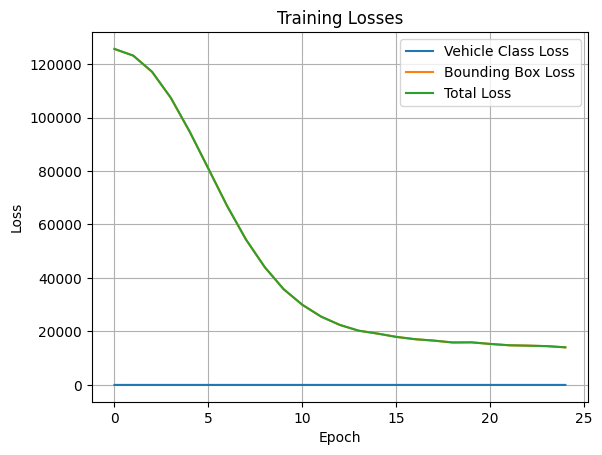

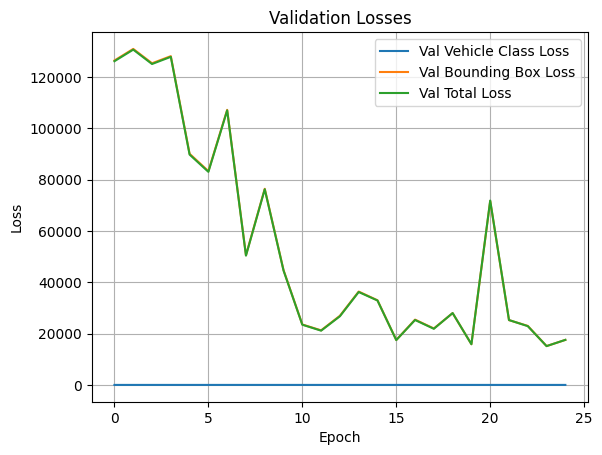

In [85]:
# Plot losses
plt.plot(history.history['vehicle_class_loss'], label='Vehicle Class Loss')
plt.plot(history.history['bounding_box_loss'], label='Bounding Box Loss')
plt.plot(history.history['loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.grid(True)
plt.show()

plt.plot(history.history['val_vehicle_class_loss'], label='Val Vehicle Class Loss')
plt.plot(history.history['val_bounding_box_loss'], label='Val Bounding Box Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Validation Losses')
plt.grid(True)
plt.show()

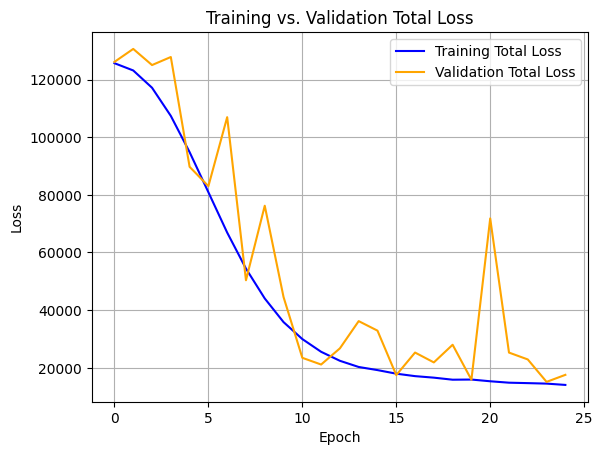

In [86]:
import matplotlib.pyplot as plt

# Plot total loss for training and validation
plt.plot(history.history['loss'], label='Training Total Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Total Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Total Loss')
plt.legend()
plt.grid(True)
plt.show()


#### Evaluate the model and check the test results

In [87]:
test_results = model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
print('\nTest results:', test_results)

28/28 - 1s - 21ms/step - bounding_box_loss: 17534.1211 - bounding_box_mae: 102.5270 - loss: 17555.2891 - vehicle_class_accuracy: 0.5895 - vehicle_class_loss: 1.3748

Test results: [17555.2890625, 1.3748270273208618, 17534.12109375, 102.5269546508789, 0.5895096659660339]


#### Run inferences on the images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step


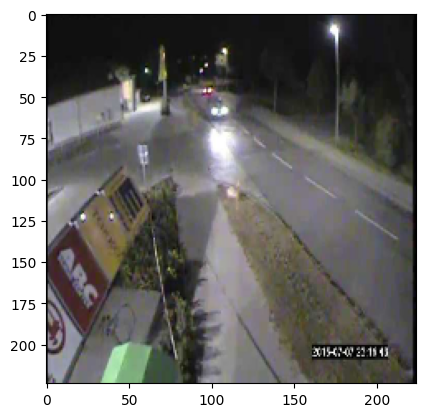

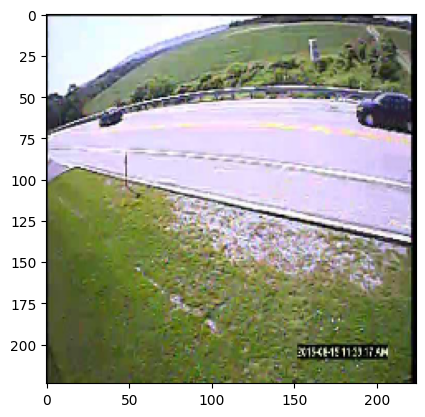

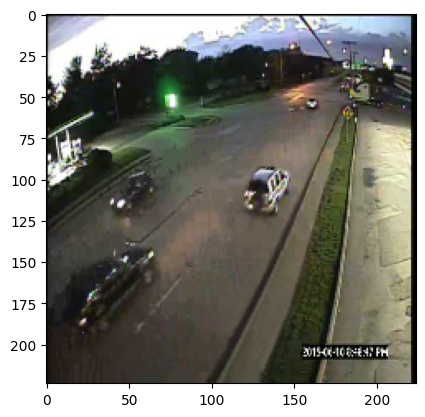

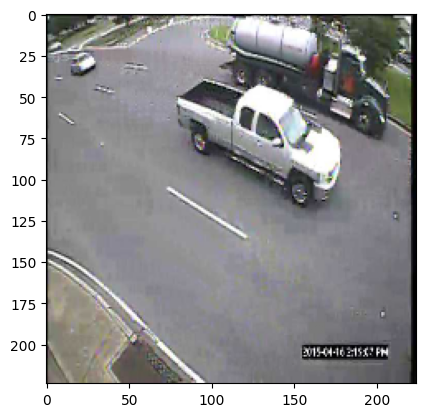

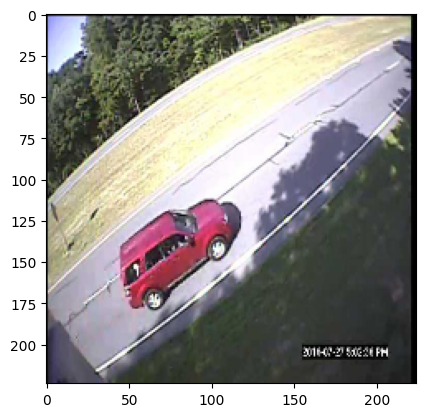

In [88]:
import matplotlib.pyplot as plt

# Choose a few sample images for inference
sample_images = X_test[:5]  # Adjust the number of sample images as needed

# Perform inference on the sample images
predictions = model.predict(sample_images)

# Extract the predicted bounding box coordinates
predicted_bounding_boxes = predictions[1]

# Visualize the sample images with predicted bounding boxes
for i in range(len(sample_images)):
    plt.figure()
    plt.imshow(sample_images[i])
    plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                     predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                     predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1],
                                     fill=False, edgecolor='r', linewidth=2))
    plt.show()